# Multiple testing correction
When analyzing LC-MS protein datasets, the objective is often to test whether a protein's expression differs between the control and disease group. The same statistical test is performed for every protein in the dataset. In this example, we simulate such a dataset and show why it is necessary to correct for *multiple testing*.
  
Given *m* null hypothesis tests, the **false discovery rate** (**FDR**) is defined as 
$$ FDR = \frac{FP}{FP + TP} $$ where $ FP $ (**false positive**) is the number of times a test is declared significant when the null hypothesis is true while $ TP $ (**true positive**) is the number of times a test is declared significant when the alternative hypothesis is true. In our case, we often quantify a large number of proteins (> 1000) and want to test whether the expression of each protein, independently from that of all others, is different between sample groups, e.g. control vs disease or different disease stages.

As a first step, we generate a data matrix, `x`, in which rows represent samples and columns variables (e.g., proteins). All data points $ x_{ij} $ are drawn from the same distribution: $ X \in N(0,1) $. We say that the first 50 samples belong to group **A** and the remaining 50 to group **B**.

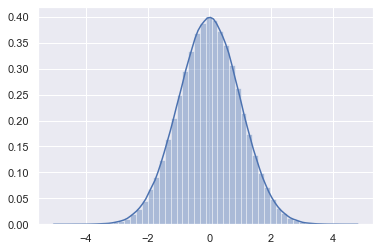

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mu = 0
sigma = 1

n = 50 # Number of samples in each group
m = 5000 # Number of variables

s = np.random.normal(mu, sigma, 2 * n * m)
x = s.reshape((n * 2, m))

sns.distplot(s)
plt.show()

## Independent two-sample *t*-test
We test if the mean of the samples in **A** is different from the mean of the samples in group **B** using the independent (unpaired) two-sample *t*-test. The *t*-statistic is calculated as: $$ t = \frac{\bar{X_{1}} - \bar{X_{2}}} {s_p \sqrt{\frac{2}{n}} }. $$ The test is done on each variable (column) independently. We then look at the histogram of the resulting *p*-values.

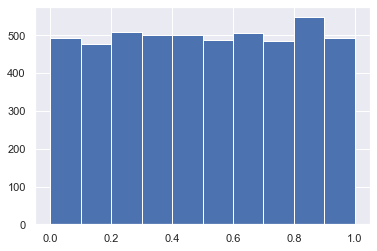

Number of variables with significant differences (p <= 0.01) between group A and B: 251


In [2]:
# First and second half of rows belong to group a and b, respectively 
(t_statistic, p_values) = stats.ttest_ind(x[:n, :], x[n:, :])

plt.hist(p_values)
plt.show()

print('Number of variables with significant differences (p <= 0.01) between group A and B:',
      np.sum(p_values <= 0.05))

Interestingly, we notice that the *p*-values seem to be uniformly distributed between 0 and 1. The explanation comes from the very definition of the *p*-value. The *p*-value is the probability, $ \alpha $, of observing a test result at least as extreme as that observed if the *null hypothesis is true*. So, if we test $m$ true null hypotheses we expect to get $ m \times \alpha $ *p*-values lower than or equal to $ \alpha $.

Using the data in `x`, we have performed 5000 tests to check if the first 50 elements of each column have a significantly different mean than the remaining 50. If we were to use a signifance threshold of $\alpha = 0.05$, we expect to find $ 0.05 \times 5000 = 250 $ variables with significant differences. These are all **false positives** since all values have been drawn from the same distribution, and the *t*-test we are using is designed to test whether the samples from group **A** and **B** come from distributions with different means.

## Introduce differences in a subset of the variables
As a second step, we introduce actual differences to the expression of 25 variables. The values of these are drawn from $ X_{up} \in N(0.75,1.00)$ instead of $ X $ for the samples in group **A** (the first 50 rows) . We then repeat the same procedure as before. 

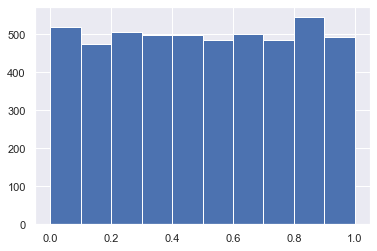

In [3]:
n_de = 25 # Number of differentially expressed variables
mu_shift = 0.75
x_upregulated = np.random.normal(mu + mu_shift, sigma, n * n_de)

x_de = x.copy()
x_de[:n, :n_de] = x_upregulated.reshape((n, n_de))

(t_statistic_de, p_values_de) = stats.ttest_ind(x_de[:n, :], x_de[n:, :])

plt.hist(p_values_de)
plt.show()

The distribution has not changed much, but we can see a small height increase in the leftmost bar.

## Calculate the FDR
As we have seen by now, we can not report all variables whose *p*-value is below 0.05 or 0.01 as significant when we have performed a large number of tests. Instead we want to find a more restrictive threshold that removes as many of the false positives while retaining true positives. We achieve this by calculating the FDR.

### Actual FDR
We calculate the FDR for a range of *p*-value thresholds, $ t_{start} \leq t_i \leq t_{end} $ in the following manner:
  1. Initialize $ t_{i=0} = t_{start} $.
  2. Estimate $ TP_i $ as the number of *p*-values lower than $ t_i $ among the upregulated variables in `x_de` and $ FP_i $ as the number of *p*-values lower than $ t_i $ in `x`.
  3. Increment $ t_{i + 1}  = t_i + \Delta t $.
  4. Repeat step 2 - 3 until $ t_i \geq t_{end} $.


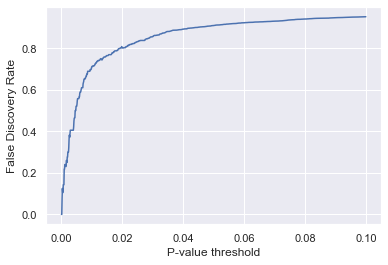

16 significantly differentially expressed variables at significance threshold p <= 0.0003 (FDR = 0.1).
14 true positives and 2 false positives.


In [8]:
sorted_indices = np.argsort(p_values_de)
p_sorted = p_values_de[sorted_indices]

pval_thresholds = np.linspace(0, 0.1, 1000)

tp = []
fp = []

for t in pval_thresholds:
    i = np.argmax(p_sorted > t)    
    tp.append(np.sum(sorted_indices[:i] < n_de))
    fp.append(np.sum(p_values < t))

eps = 1e-15 # To avoid division by zero
tp = np.array(tp)
fp = np.array(fp)

fdr = fp / (tp + fp + eps)

plt.plot(pval_thresholds, fdr)
plt.xlabel('P-value threshold')
plt.ylabel('False Discovery Rate')
plt.show()


t_01 = pval_thresholds[np.argmax(fdr > 0.1)]
i_01 = np.argmax(p_sorted > t_01)

print('{} significantly differentially expressed variables at significance threshold p <= {} (FDR = 0.1).'.
      format(np.sum(p_sorted < t_01), np.round(t_01, 4)))
print('{} true positives and {} false positives.'
      .format(np.sum(sorted_indices[:i_01] < n_de), np.sum(p_values <= t_01)))

### Estimated FDR
In this simulated dataset we know which variables are differentially expressed and which are not. Thus, we can simply count $ TP $ and $ FP $ for various *p*-value thresholds. In real datasets, however, we do not know which proteins are differentially expressed beforehand and consequently we can only estimate the FDR. We do this by utilizing our knowledge about the *p*-value distribution under the null hypothesis. Given a *p*-value threshold, $ \alpha $, and $ m $ number of tests, let $ R $ be the number of observed rejections of the null hypothesis, $V = \alpha \times m = FP_{estimated}$ the estimated number of false rejections, and $ S = R - V = TP_{estimated} $ the estimated number of true rejections. The estimated FDR then becomes: $$ FDR_{estimated} = \frac{FP_{estimated}}{FP_{estimated} + TP_{estimated}} = \frac{V}{V + S} = \frac{V}{V + (R - V)} = \frac{V}{R}. $$ 

We estimate the FDR on our simulated data and compare it to the actual FDR:

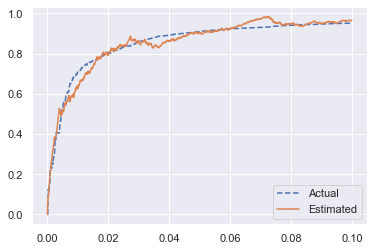

In [5]:
fdr_estimated = [t * m / np.max([np.sum(p_sorted < t), eps]) # np.max to avoid division by zero
                 for t in pval_thresholds]

_, axs = plt.subplots()
axs.plot(pval_thresholds, fdr, '--', label='Actual')
axs.plot(pval_thresholds, fdr_estimated, label='Estimated')
axs.legend(loc='best')
plt.show()

## Conclusions
If we would have used a larger difference in mean expression, `mu_delta`, we could have used a *p*-value threshold that completely separates true positives from false. A lower number of false variables, i.e., a lower `m`, would enable us to use a gentler threshold while still maintaining a low FDR.